### Tensorflow Implementation
- Sequential Model
- Monitoring training as well as test (Validation)
- L2 Regularization
- Dropouts
- Batch Norm
- Early Stopping

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score

from sklearn.preprocessing  import StandardScaler, LabelEncoder

import tensorflow as tf

In [2]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)           # Set random seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# TEST_SIZE = 0.2
ALPHA = 0.001
WEIGHT_DECAY = 0.001     # For regularization
EPOCHS = 200
BATCH_SIZE = 16

TRAIN_SIZE = int(BATCH_SIZE*18)
PATIENCE = 20          # for early stopping
LR_PATIENCE = 10
LR_FACTOR = 0.1       # by what factor we are reducing the lr

params = {'legend.fontsize': 'medium',
          'figure.figsize' : (15,6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
          }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### BASICS

In [3]:
# # for, Physical device :

# physical_device = tf.config.list_physical_devices('GPU')
# if len(physical_device) > 0:
#   tf.config.experimental.set_memory_growth(physical_device[0], True)          code this only when you are working on local machine and using GPU and you don't want tensorflow to occupy the whole GPU at once and give access to other fn to utilise GPU

In [4]:
# Location of the directories :

inpDir = os.path.join('..','..','input')
outDir = os.path.join('..','output')
subDir = 'ionosphere'
modelDir = os.path.join('..','models')

In [5]:
# whenever we are working using inpDir and subDir on out machine, then

# data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data), header=None)
# data_df.head()

In [6]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/ionosphere.data', header=None)

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       351 non-null    int64  
 1   1       351 non-null    int64  
 2   2       351 non-null    float64
 3   3       351 non-null    float64
 4   4       351 non-null    float64
 5   5       351 non-null    float64
 6   6       351 non-null    float64
 7   7       351 non-null    float64
 8   8       351 non-null    float64
 9   9       351 non-null    float64
 10  10      351 non-null    float64
 11  11      351 non-null    float64
 12  12      351 non-null    float64
 13  13      351 non-null    float64
 14  14      351 non-null    float64
 15  15      351 non-null    float64
 16  16      351 non-null    float64
 17  17      351 non-null    float64
 18  18      351 non-null    float64
 19  19      351 non-null    float64
 20  20      351 non-null    float64
 21  21      351 non-null    float64
 22  22

In [8]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,351.0,0.891738,0.311155,0.0,1.000000,1.00000,1.000000,1.0
1,351.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0
2,351.0,0.641342,0.497708,-1.0,0.472135,0.87111,1.000000,1.0
3,351.0,0.044372,0.441435,-1.0,-0.064735,0.01631,0.194185,1.0
4,351.0,0.601068,0.519862,-1.0,0.412660,0.80920,1.000000,1.0
5,351.0,0.115889,0.460810,-1.0,-0.024795,0.02280,0.334655,1.0
6,351.0,0.550095,0.492654,-1.0,0.211310,0.72873,0.969240,1.0
7,351.0,0.119360,0.520750,-1.0,-0.054840,0.01471,0.445675,1.0
8,351.0,0.511848,0.507066,-1.0,0.087110,0.68421,0.953240,1.0
9,351.0,0.181345,0.483851,-1.0,-0.048075,0.01829,0.534195,1.0


In [9]:
labels = data_df[data_df.columns[-1]]
features_df = data_df.drop(data_df.columns[-1], axis=1)
features_df.shape, labels.shape

((351, 34), (351,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, train_size=TRAIN_SIZE, stratify=labels, random_state=RANDOM_STATE)

X_train.shape,X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

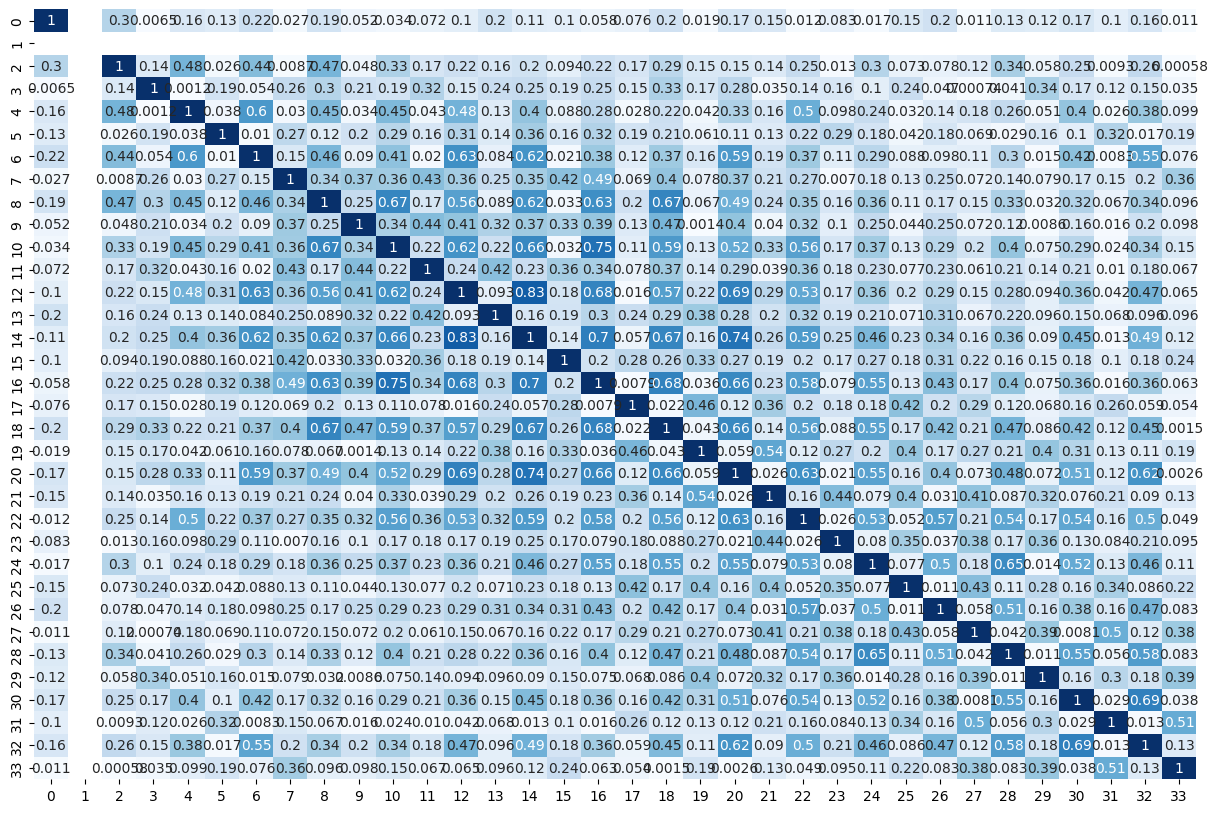

In [11]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(features_df.corr().abs(), ax = ax, cmap='Blues', annot= True, fmt='.2g', cbar=False);

Make the model clean and never let out model asume anything on its own. So its always a good option to do encoding. Hence, here we do label encoding.

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
class_names = list(le.classes_)
class_names

['b', 'g']

In [14]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

All the above are numpy nd arrays(s)

### MODEL

This model takes the input as a list.

In [15]:
# Sequential Model
# another way to define the model is:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = tf.keras.Sequential([

    tf.keras.Input(shape=(X_train.shape[1], )),

    tf.keras.layers.Dense(26, activation='relu', kernel_initializer = initializer),  # First Hidden Layer

    tf.keras.layers.Dense(18, activation='relu', kernel_initializer = initializer),  # Second Hidden Layer

    tf.keras.layers.Dense(10, activation='relu', kernel_initializer = initializer),  # Third Hidden Layer

    tf.keras.layers.Dense(2, kernel_initializer = initializer)    # Output Layer
])

In [16]:
model.summary()             # reduicng the layers by 8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 26)             │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608 (6.28 KB)

 Trainable params: 1,608 (6.28 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer = optimizer, loss = loss_fn, metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
18/18 - 5s - 264ms/step - accuracy: 0.4271 - loss: 0.7461 - val_accuracy: 0.5714 - val_loss: 0.6267
Epoch 2/200
18/18 - 0s - 16ms/step - accuracy: 0.7188 - loss: 0.5881 - val_accuracy: 0.8095 - val_loss: 0.5298
Epoch 3/200
18/18 - 0s - 20ms/step - accuracy: 0.8785 - loss: 0.5005 - val_accuracy: 0.8254 - val_loss: 0.4639
Epoch 4/200
18/18 - 1s - 31ms/step - accuracy: 0.8993 - loss: 0.4213 - val_accuracy: 0.8254 - val_loss: 0.4084
Epoch 5/200
18/18 - 0s - 17ms/step - accuracy: 0.9201 - loss: 0.3493 - val_accuracy: 0.8730 - val_loss: 0.3631
Epoch 6/200
18/18 - 1s - 33ms/step - accuracy: 0.9340 - loss: 0.2915 - val_accuracy: 0.8730 - val_loss: 0.3291
Epoch 7/200
18/18 - 0s - 11ms/step - accuracy: 0.9375 - loss: 0.2486 - val_accuracy: 0.8730 - val_loss: 0.2998
Epoch 8/200
18/18 - 0s - 9ms/step - accuracy: 0.9479 - loss: 0.2155 - val_accuracy: 0.8889 - val_loss: 0.2712
Epoch 9/200
18/18 - 0s - 9ms/step - accuracy: 0.9479 - loss: 0.1892 - val_accuracy: 0.8889 - val_loss: 0.2428
Ep

In [19]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.427083,0.746122,0.571429,0.626668
1,0.718750,0.588094,0.809524,0.529782
2,0.878472,0.500494,0.825397,0.463894
3,0.899306,0.421327,0.825397,0.408420
4,0.920139,0.349292,0.873016,0.363098


In [20]:
def fn_plot_tf_hist(hist_df):

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    # print(best)

    props = dict(boxstyle = 'round', facecolor = 'aqua', alpha = 0.4)
    facecolor = 'cyan'
    fontsize = 12
    CMAP = plt.cm.coolwarm
    ax = axes[0]

    hist_df.plot(y=[y2,y4], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y2].min(), hist_df.iloc[-1][y4])


    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Min : {best[y4].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy()[0], best[y4].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy()[0], best[y4].to_numpy()[0] + offset),   #end
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy()[0], color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())

    ax.grid()


    ax = axes[1]
    hist_df.plot(y=[y1,y3], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y1], hist_df.iloc[-1][y3])

    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Best : {best[y3].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0] + offset),
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy(), color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y1.capitalize())

    ax.grid()
    plt.suptitle('Training Perfromance')
    plt.tight_layout()
    plt.show()
    # ax = axes[1]
    # hist_df.plot(y=[y2,y4], ax=axes[0])
    # hist_df.plot(y=[y1,y3], ax=ax)

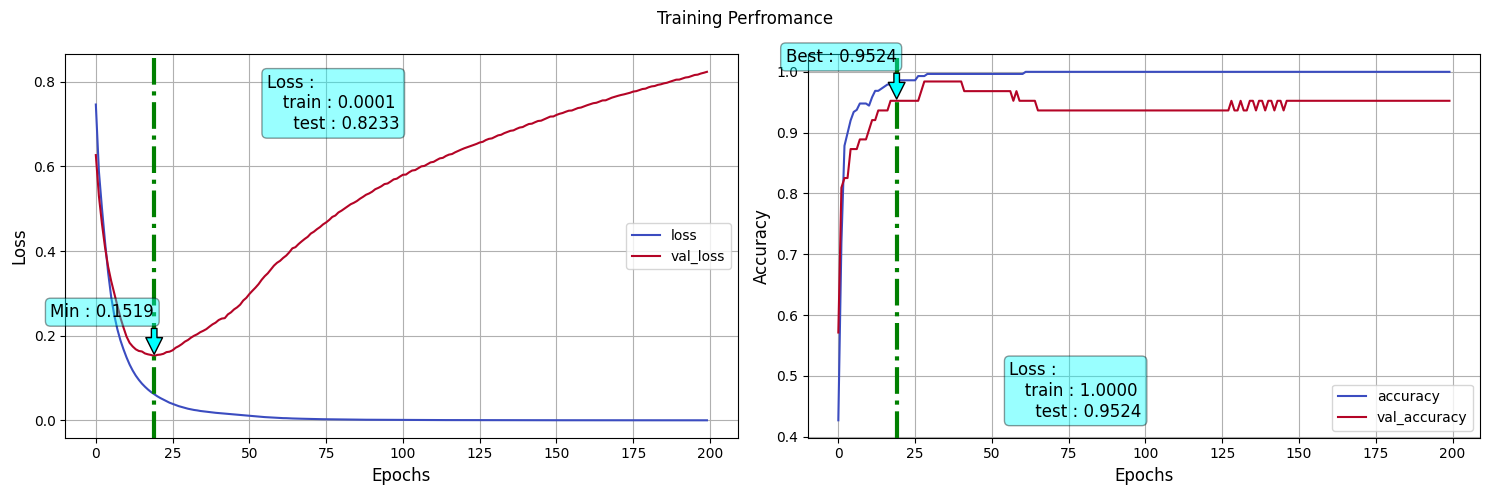

In [21]:
fn_plot_tf_hist(loss_df)

In [22]:
pred = model(X_train[:1]).numpy()
pred

array([[ 19.351252, -18.64196 ]], dtype=float32)

In [23]:
# Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1], pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

Train Predictions

In [24]:
pred_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

y_pred = pred_model(X_train).numpy()

print(f'Accuracy :{accuracy_score(y_train, y_pred.argmax(axis=1)):7.4f}')

Accuracy : 1.0000


In [25]:
print(classification_report(y_train, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       185

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



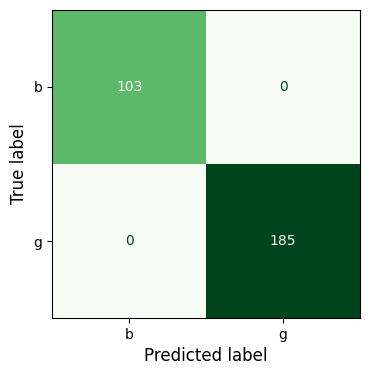

In [26]:
display_labels = class_names

cm = confusion_matrix(y_train, y_pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= display_labels)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Greens', colorbar=False)

Test Predictions

In [27]:
y_true, y_pred = [], []


pred = pred_model(X_test)
y_pred = pred.numpy().argmax(axis=1)
y_true = y_test

len(y_true), len(y_pred)

(63, 63)

### L2 *Regularization*

In [28]:
del initializer
del optimizer
del loss_fn
del model

In [29]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

regularizer = tf.keras.regularizers.L2(l2=0.05)

model = tf.keras.Sequential([

    tf.keras.Input(shape=(X_train.shape[1], )),

    tf.keras.layers.Dense(26, activation='relu', kernel_regularizer = regularizer , kernel_initializer = initializer),  # First Hidden Layer

    tf.keras.layers.Dense(18, activation='relu',kernel_regularizer = regularizer , kernel_initializer = initializer),  # Second Hidden Layer

    tf.keras.layers.Dense(10, activation='relu',kernel_regularizer = regularizer ,kernel_initializer = initializer),  # Third Hidden Layer

    tf.keras.layers.Dense(2,kernel_regularizer = regularizer , kernel_initializer = initializer)    # Output Layer
])


model.compile(optimizer = optimizer, loss = loss_fn, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
18/18 - 4s - 213ms/step - accuracy: 0.4028 - loss: 3.7210 - val_accuracy: 0.4921 - val_loss: 3.4401
Epoch 2/200
18/18 - 1s - 39ms/step - accuracy: 0.6319 - loss: 3.2652 - val_accuracy: 0.7937 - val_loss: 3.0526
Epoch 3/200
18/18 - 0s - 17ms/step - accuracy: 0.8438 - loss: 2.9094 - val_accuracy: 0.8571 - val_loss: 2.7311
Epoch 4/200
18/18 - 0s - 16ms/step - accuracy: 0.8715 - loss: 2.6021 - val_accuracy: 0.8730 - val_loss: 2.4495
Epoch 5/200
18/18 - 0s - 9ms/step - accuracy: 0.8889 - loss: 2.3294 - val_accuracy: 0.8730 - val_loss: 2.1987
Epoch 6/200
18/18 - 0s - 17ms/step - accuracy: 0.8958 - loss: 2.0868 - val_accuracy: 0.8889 - val_loss: 1.9768
Epoch 7/200
18/18 - 0s - 17ms/step - accuracy: 0.9167 - loss: 1.8722 - val_accuracy: 0.9048 - val_loss: 1.7814
Epoch 8/200
18/18 - 0s - 14ms/step - accuracy: 0.9271 - loss: 1.6833 - val_accuracy: 0.9048 - val_loss: 1.6116
Epoch 9/200
18/18 - 0s - 16ms/step - accuracy: 0.9340 - loss: 1.5194 - val_accuracy: 0.9048 - val_loss: 1.4654
E

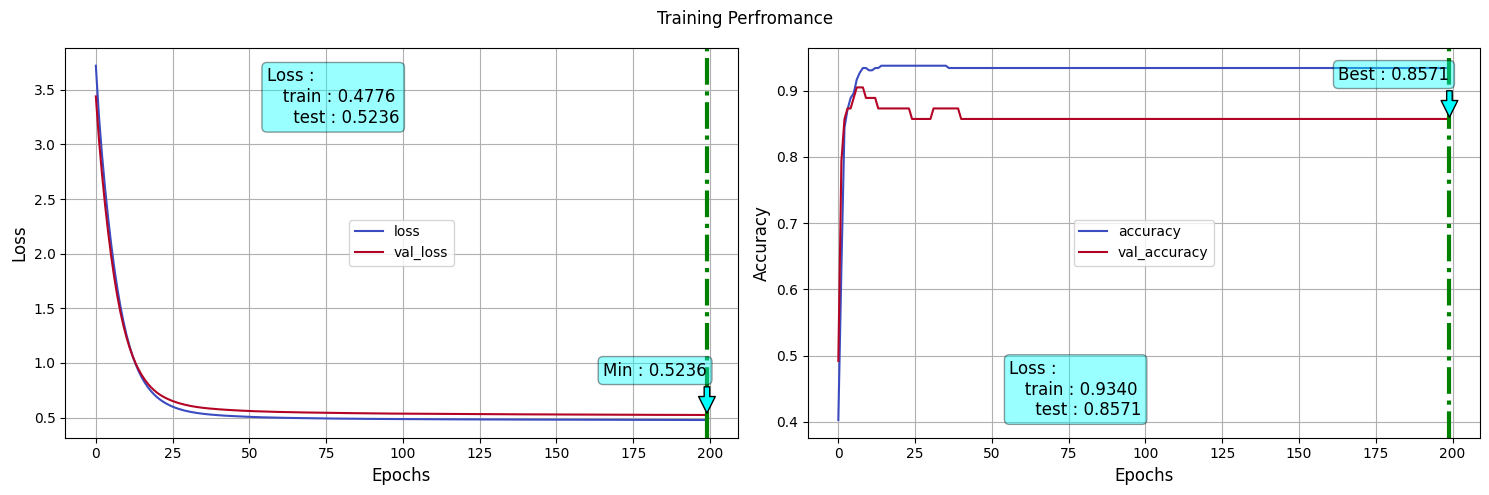

In [30]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [31]:
del initializer
del optimizer
del loss_fn
del model

In [32]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

activation = 'relu'

model = tf.keras.Sequential([

    tf.keras.Input(shape=(X_train.shape[1], )),
    ##------------
    ## Set - 1
    ##------------
    tf.keras.layers.Dense(26, kernel_initializer = initializer),  # First Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 2
    ## -----------

    tf.keras.layers.Dense(18, kernel_initializer = initializer),  # Second Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 3
    ## -----------

    tf.keras.layers.Dense(10, kernel_initializer = initializer),  # Third Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 4
    ## -----------
    tf.keras.layers.Dense(2, kernel_initializer = initializer)    # Output Layer
])


model.compile(optimizer = optimizer, loss = loss_fn, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
18/18 - 4s - 207ms/step - accuracy: 0.6042 - loss: 0.7197 - val_accuracy: 0.4762 - val_loss: 0.6857
Epoch 2/200
18/18 - 0s - 18ms/step - accuracy: 0.7465 - loss: 0.5742 - val_accuracy: 0.7778 - val_loss: 0.5748
Epoch 3/200
18/18 - 0s - 16ms/step - accuracy: 0.8438 - loss: 0.4872 - val_accuracy: 0.8730 - val_loss: 0.5080
Epoch 4/200
18/18 - 0s - 17ms/step - accuracy: 0.8750 - loss: 0.4278 - val_accuracy: 0.8730 - val_loss: 0.4635
Epoch 5/200
18/18 - 0s - 17ms/step - accuracy: 0.8924 - loss: 0.3833 - val_accuracy: 0.8730 - val_loss: 0.4236
Epoch 6/200
18/18 - 0s - 15ms/step - accuracy: 0.9132 - loss: 0.3448 - val_accuracy: 0.9048 - val_loss: 0.3877
Epoch 7/200
18/18 - 0s - 16ms/step - accuracy: 0.9236 - loss: 0.3114 - val_accuracy: 0.9365 - val_loss: 0.3550
Epoch 8/200
18/18 - 0s - 11ms/step - accuracy: 0.9375 - loss: 0.2803 - val_accuracy: 0.9365 - val_loss: 0.3266
Epoch 9/200
18/18 - 0s - 12ms/step - accuracy: 0.9444 - loss: 0.2516 - val_accuracy: 0.9365 - val_loss: 0.3025


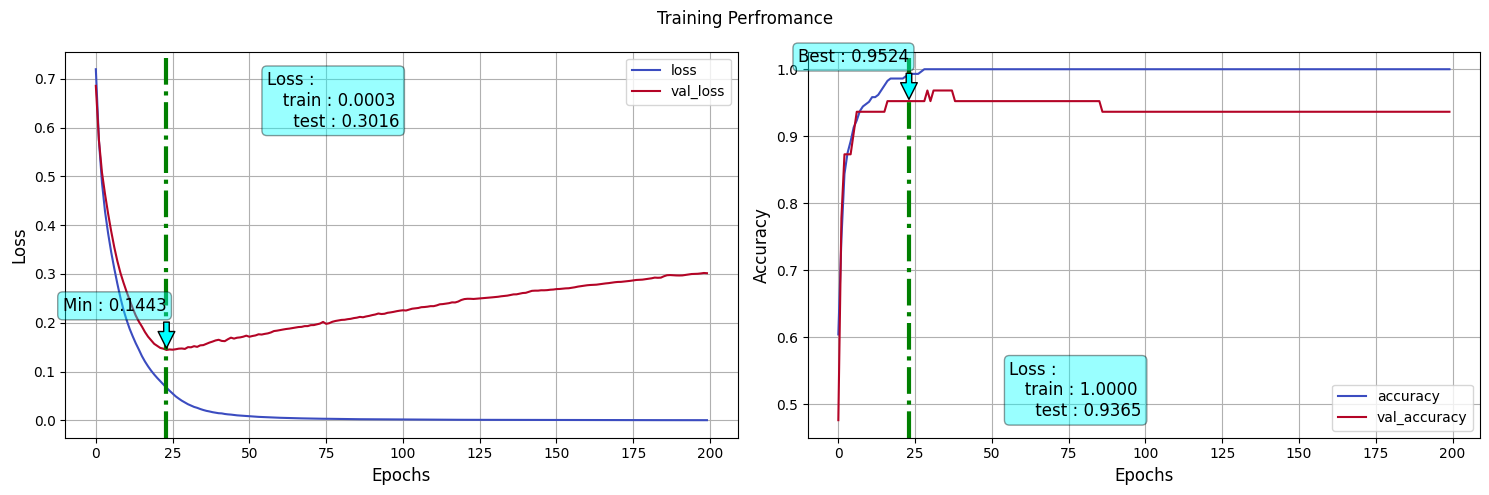

In [33]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [34]:
pred_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

y_pred = pred_model(X_train).numpy()

print(f'Accuracy :{accuracy_score(y_train, y_pred.argmax(axis=1)):7.4f}')

Accuracy : 0.9688


In [35]:
print(classification_report(y_train, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       103
           1       0.95      1.00      0.98       185

    accuracy                           0.97       288
   macro avg       0.98      0.96      0.97       288
weighted avg       0.97      0.97      0.97       288



In [36]:
def fn_plot_confusion_matrix(y_test, y_pred, labels):

  display_labels = class_names

  cm = confusion_matrix(y_train, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= display_labels)

  fig, ax = plt.subplots(figsize = (4,4))

  disp.plot(ax = ax, cmap = 'Greens', colorbar=False)

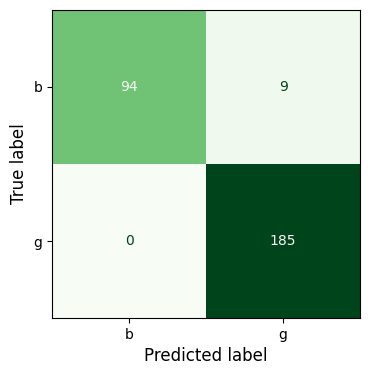

In [37]:
fn_plot_confusion_matrix(y_test, y_pred.argmax(axis=1), labels=class_names)

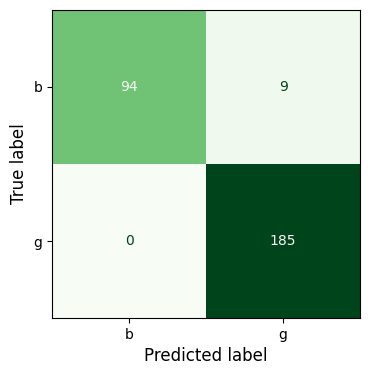

In [38]:
display_labels = class_names

cm = confusion_matrix(y_train, y_pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= display_labels)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Greens', colorbar=False)

## DropOut
0.2-0.3-0.4

In [39]:
del initializer
del optimizer
del loss_fn
del model

In [40]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

activation = 'relu'

dor1 = 0.4     # drop out rate : here linearly increasing
dor2 = 0.3
dor3 = 0.2


model = tf.keras.Sequential([

    tf.keras.Input(shape=(X_train.shape[1], )),
    ##------------
    ## Set - 1
    ##------------
    tf.keras.layers.Dense(26, kernel_initializer = initializer),  # First Hidden Layer
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),
    tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE),


    ##------------
    ## Set 2
    ## -----------

    tf.keras.layers.Dense(18, kernel_initializer = initializer),  # Second Hidden Layer
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),
    tf.keras.layers.Dropout(rate=dor2, seed=RANDOM_STATE),

    ##------------
    ## Set 3
    ## -----------

    tf.keras.layers.Dense(10, kernel_initializer = initializer),  # Third Hidden Layer
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),
    tf.keras.layers.Dropout(rate=dor3, seed=RANDOM_STATE),

    ##------------
    ## Set 4
    ## -----------
    tf.keras.layers.Dense(2, kernel_initializer = initializer)    # Output Layer
])


model.compile(optimizer = optimizer, loss = loss_fn, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = EPOCHS ,
                    batch_size=BATCH_SIZE, verbose=2)

Epoch 1/200
18/18 - 2s - 118ms/step - accuracy: 0.3854 - loss: 0.9070 - val_accuracy: 0.5079 - val_loss: 0.6581
Epoch 2/200
18/18 - 0s - 23ms/step - accuracy: 0.5104 - loss: 0.7024 - val_accuracy: 0.7778 - val_loss: 0.5811
Epoch 3/200
18/18 - 0s - 8ms/step - accuracy: 0.6354 - loss: 0.6312 - val_accuracy: 0.8095 - val_loss: 0.5456
Epoch 4/200
18/18 - 0s - 11ms/step - accuracy: 0.7083 - loss: 0.6085 - val_accuracy: 0.8571 - val_loss: 0.5153
Epoch 5/200
18/18 - 0s - 17ms/step - accuracy: 0.7292 - loss: 0.5790 - val_accuracy: 0.8730 - val_loss: 0.4855
Epoch 6/200
18/18 - 0s - 17ms/step - accuracy: 0.7222 - loss: 0.5601 - val_accuracy: 0.8889 - val_loss: 0.4632
Epoch 7/200
18/18 - 0s - 12ms/step - accuracy: 0.7951 - loss: 0.5221 - val_accuracy: 0.8889 - val_loss: 0.4409
Epoch 8/200
18/18 - 0s - 14ms/step - accuracy: 0.8229 - loss: 0.4926 - val_accuracy: 0.9048 - val_loss: 0.4221
Epoch 9/200
18/18 - 0s - 16ms/step - accuracy: 0.8264 - loss: 0.4805 - val_accuracy: 0.9048 - val_loss: 0.4038
E

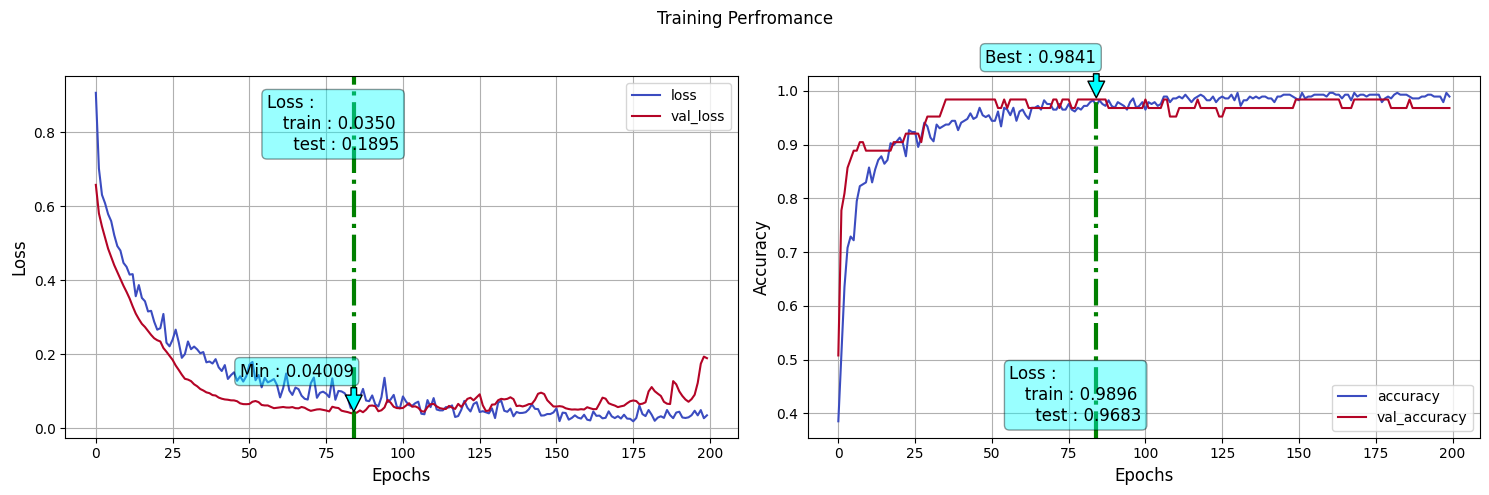

In [41]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

### Dropout, Batch Norm, Early Stopping, Learning rate Schedule, Save Checkpoints

In [42]:
del initializer
del optimizer
del loss_fn
del model

In [43]:
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

activation = 'relu'

model = tf.keras.Sequential([

    tf.keras.Input(shape=(X_train.shape[1], )),
    ##------------
    ## Set - 1
    ##------------
    tf.keras.layers.Dense(26, kernel_initializer = initializer),  # First Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 2
    ## -----------

    tf.keras.layers.Dense(18, kernel_initializer = initializer),  # Second Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 3
    ## -----------

    tf.keras.layers.Dense(10, kernel_initializer = initializer),  # Third Hidden Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation=activation),

    ##------------
    ## Set 4
    ## -----------
    tf.keras.layers.Dense(2, kernel_initializer = initializer)    # Output Layer
])

model.compile(optimizer = optimizer, loss = loss_fn, metrics=['accuracy'])

In [44]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'all_in.keras')

chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor = 'val_loss',
    verbose=2,
    save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = PATIENCE,
    verbose=2,
    restore_best_weights = True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 2,
    min_lr = 1e-6)

In [45]:
history = model.fit(x= X_train,
                    y= y_train,
                    validation_data=[X_test, y_test],
                    epochs = EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [chkpt_callback,es_callback,lr_callback],
                    verbose=2)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68566, saving model to ../models/ionosphere/all_in.keras
18/18 - 4s - 197ms/step - accuracy: 0.6042 - loss: 0.7197 - val_accuracy: 0.4762 - val_loss: 0.6857 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 0.68566 to 0.57485, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 18ms/step - accuracy: 0.7465 - loss: 0.5742 - val_accuracy: 0.7778 - val_loss: 0.5748 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 0.57485 to 0.50797, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 13ms/step - accuracy: 0.8438 - loss: 0.4872 - val_accuracy: 0.8730 - val_loss: 0.5080 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 0.50797 to 0.46353, saving model to ../models/ionosphere/all_in.keras
18/18 - 0s - 15ms/step - accuracy: 0.8750 - loss: 0.4278 - val_accuracy: 0.8730 - val_loss: 0.4635 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss impr

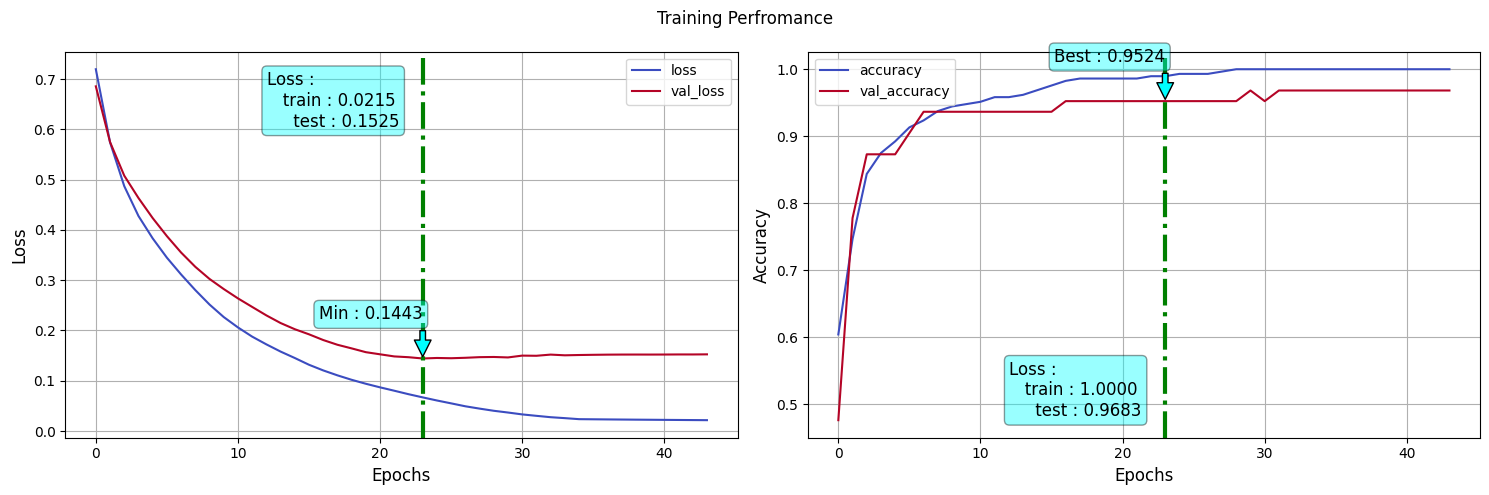

In [46]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)